# Experiments with GloVE embeddings

To get data:

1. Run `python scripts/download_glove.py`
2. Wait for it...
3. Proceed.

In [6]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import pairwise_distances
import pandas as pd
import re

## Reading data files

In [7]:
with open('../data/questions-words.txt', 'r') as f:
    data = f.read()
print(len(data))

603955


In [8]:
# Reading analogies
titles = re.findall(':.*\n', data)
contents = re.split(':.*\n', data)

metaphors = {}
for idx, s in enumerate(titles):
    title = s.replace('\n', '').replace(': ', '').rstrip().lstrip()
    lines = contents[idx+1].split('\n')
    g1 = []
    g2 = []
    for line in lines:
        if len(line) < 5:
            continue
        #print(line)
        a, b, c, d = line.split(' ')
        if (a not in g1) and (b not in g2):
            g1.append(a)
            g2.append(b)
        if (c not in g1) and (d not in g2):
            g1.append(c)
            g2.append(d)
    metaphors[title] = [g1, g2]

In [14]:
# Load GloVe embeddings
fnames = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
def load_glove(fname):
    embed_dict = {}
    with open('../data/' + fname,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:],'float32')
            embed_dict[word]=vector
    return embed_dict

In [15]:
def embedding_space(word_list, embed_dict):
    x = [embed_dict[w.lower()] for w in word_list]
    x = np.array(x)
    return x

In [68]:
def topology_experiment(metaphors, embed_dict, k):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)
        if type(k)==float:
            k_ = int(k*len(metaphors[category][0]))
        else:
            k_ = k
        a = gs.mean_neighborhood_similarity_from_points(e1, e2, k_)
        results[category] = (a, len(g1))
    return results

## Topology vs. K


In [81]:
fname = fnames[0]
embed_dict = load_glove(fname)
print("Loaded")


Loaded


In [82]:

sg = {}
for category in tqdm(metaphors.keys()):
    sg[category] = []
    g1 = metaphors[category][0]
    g2 = metaphors[category][1]
    e1 = embedding_space(g1, embed_dict)
    e2 = embedding_space(g2, embed_dict)
    ks = list(range(1, len(metaphors[category][0])-1))
    for idx, k in enumerate(ks):
        s = gs.mean_neighborhood_similarity_from_points(e1, e2, k)
        sg[category].append(s)

100%|██████████| 14/14 [00:00<00:00, 15.45it/s]


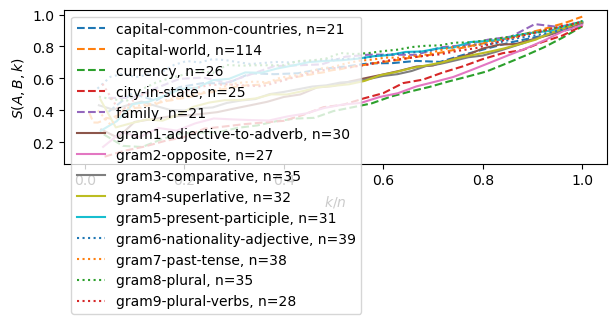

In [89]:
plt.figure(figsize=(7,2))
styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for idx, category in enumerate(sg.keys()):
    ks = np.array(list(range(1, len(sg[category])+1)))
    plt.plot(ks/len(ks), sg[category], label=f'{category}, n={len(sg[category])}', linestyle=styles[idx])

    
plt.legend()
plt.xlabel('$k/n$')
plt.ylabel('$S(A,B,k)$')
plt.show()

In [63]:

def analogy_experiment(metaphors, embed_dict):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)

        acc = 0
        tries = 0        
        for i in range(len(g1)):
            for j in range(i+1, len(g1)):
                tries += 1
                w = e1[i,:] - e2[i,:] + e1[j,:]
                w = w.reshape( (1,-1))
                p = pairwise_distances(w, e2, metric='cosine')
                if np.argmin(p)==j:
                    acc += 1
        
        results[category] = (acc/tries, len(g1))
    return results

In [69]:
res = {}
res2 = {}
for fname in fnames:
    print(fname)
    embed_dict = load_glove(fname)
    res[fname] = topology_experiment(metaphors, embed_dict, 0.2)
    res2[fname] = analogy_experiment(metaphors, embed_dict)

glove.6B.50d.txt
4
23
5
5
4
6
5
7
6
6
8
8
7
6
glove.6B.100d.txt
4
23
5
5
4
6
5
7
6
6
8
8
7
6
glove.6B.200d.txt
4
23
5
5
4
6
5
7
6
6
8
8
7
6
glove.6B.300d.txt
4
23
5
5
4
6
5
7
6
6
8
8
7
6


In [26]:
categories = res[fname].keys()

r1, r2, c = [], [], []
for cat in categories:
    r1 = r1 + [res[f][cat][0] for f in fnames]
    r2 = r2 + [res2[f][cat][0] for f in fnames]
    c = c + fnames
st.pearsonr(r1, r2)

PearsonRResult(statistic=0.7584120626072491, pvalue=1.2869450116898026e-11)

In [27]:
categories = list(res[fname].keys())
for i in range(len(r1)//4):
    r1_ = r1[i*4:(i+1)*4]
    r2_ = r2[i*4:(i+1)*4]
    
    print(categories[i], st.pearsonr(r1_, r2_))

capital-common-countries PearsonRResult(statistic=-0.930238139883426, pvalue=0.06976186011657415)
capital-world PearsonRResult(statistic=0.8749178506313351, pvalue=0.1250821493686649)
currency PearsonRResult(statistic=-0.5599247807094304, pvalue=0.4400752192905695)
city-in-state PearsonRResult(statistic=0.947777961733136, pvalue=0.05222203826686389)
family PearsonRResult(statistic=0.9757939136848547, pvalue=0.024206086315145203)
gram1-adjective-to-adverb PearsonRResult(statistic=0.7651952546310681, pvalue=0.23480474536893192)
gram2-opposite PearsonRResult(statistic=0.9764870783676891, pvalue=0.02351292163231089)
gram3-comparative PearsonRResult(statistic=0.47535312341343516, pvalue=0.5246468765865648)
gram4-superlative PearsonRResult(statistic=-0.7495322839641432, pvalue=0.2504677160358568)
gram5-present-participle PearsonRResult(statistic=-0.42865522390449395, pvalue=0.5713447760955059)
gram6-nationality-adjective PearsonRResult(statistic=-0.9507442341601534, pvalue=0.0492557658398467

In [73]:
df = pd.DataFrame()
df['topology'] = r1
df['analogy'] = r2
df['files'] = ['_'.join(c_.split('.')[:-1]) for c_ in c]
df.head()

,topology,analogy,files
0,0.660166,0.837945,glove_6B_50d
1,0.617889,0.956522,glove_6B_100d
2,0.598619,0.996047,glove_6B_200d
3,0.621132,0.996047,glove_6B_300d
4,0.400672,0.535082,glove_6B_50d


In [74]:
for i in range(4):
    s= df.iloc[i::4][['topology', 'analogy']]
    print(df.iloc[i]['files'])
    print(s.corr())

glove_6B_50d
          topology   analogy
topology  1.000000  0.847735
analogy   0.847735  1.000000
glove_6B_100d
          topology   analogy
topology  1.000000  0.773072
analogy   0.773072  1.000000
glove_6B_200d
          topology   analogy
topology  1.000000  0.775363
analogy   0.775363  1.000000
glove_6B_300d
          topology  analogy
topology   1.00000  0.80344
analogy    0.80344  1.00000


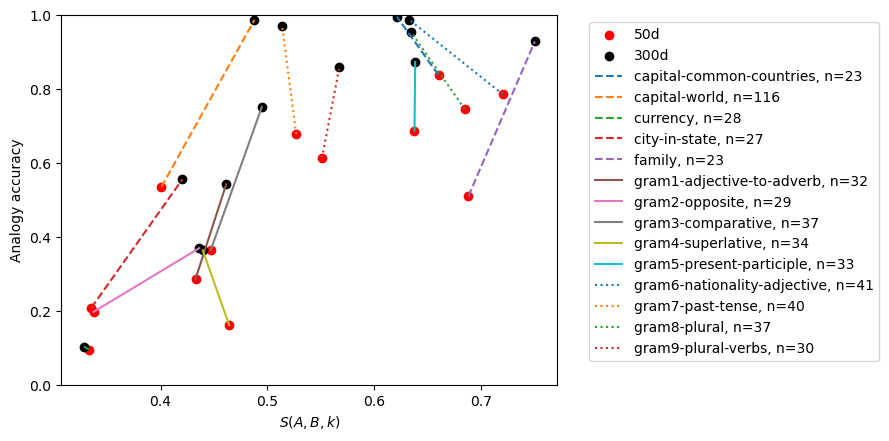

In [92]:
colors = ['r', 'g', 'b', 'k']
legends = ['50d', '100d', '200d', '300d']

plt.figure()
for j in range(4):
    if j == 1 or j ==2:
        continue
    plt.scatter(df.iloc[j::4]['topology'], df.iloc[j::4]['analogy'], c=colors[j], label=legends[j])

styles = ['--'] * 5 + ['-'] * 5 + [':'] * 5
for i in range(14):
    x = df['topology'][i*4:i*4+4]
    y = df['analogy'][i*4:i*4+4]
    plt.plot(x.iloc[[0, 3]], y.iloc[[0, 3]], label=f'{categories[i]}, n={len(metaphors[categories[i]][0])}', linestyle=styles[i])
    #plt.plot(x, y, label=categories[i], linestyle=styles[i])
plt.xlabel('$S(A,B,k)$')
plt.ylabel('Analogy accuracy')
#plt.xlim([0.2,.6])
plt.ylim([0,1])
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('GLoVe embeddings and Structural distance')
plt.savefig('glove.pdf', bbox_inches='tight')
plt.show()